<a href="https://colab.research.google.com/github/monteroanibal/diplomado_GEOIA_IGAC2025/blob/main/Interm_Modulo_07_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Notebook de la sesión

---

# 1. Cargue de librerías

Para explorar archivos y borrarlos.

In [1]:
import glob
import os
import shutil

Para manipular objetos y métodos de Numpy.

In [2]:
import numpy as np

Para importar los ráster. la función show permite graficar los ráster de una forma básica.

In [3]:
%%capture
!pip install rasterio
import rasterio as rs

Para hacer los histogramas del las bandas del ráster.

In [4]:
from rasterio.plot import show_hist

Para construir y manipular los datasets de entrada.

In [5]:
import pandas as pd

Para desplegar los gráficos y para ver los rasters.

In [6]:
from rasterio.plot import show

In [7]:
import matplotlib.pyplot as plt

In [8]:
import plotly.express as px
import seaborn as sns

Para entrenar y extraer los labels de los clusters.

In [9]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
from sklearn.decomposition import PCA

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

Para tomar el tiempo de ejecución de los métodos anteriores.

In [13]:
from time import time

# 2. Lectura y primera exploración de datos ráster



Se descarga la imagen compuesta Sentinel de Chía de 2018 que está publicada en Github.

In [17]:
%%capture
!wget https://github.com/monteroanibal/diplomado_GEOIA_IGAC2025/raw/refs/heads/main/Insumos/Interm_Modulo_07_Datos/Interm_Modulo_07_Sentinel2_MSI_Level2A_Chiia_2018.tif

Se especifica la ruta del archivo descargado para ser importada.

In [18]:
f = '/content/Interm_Modulo_07_Sentinel2_MSI_Level2A_Chiia_2018.tif'

In [19]:
src = rs.open(f)

Se normalizan los valores contenidos en cada banda del ráster para desplegar la imagen a color.

In [20]:
nrmlzd = src.read()
nrmlzd[nrmlzd > nrmlzd.max()/3] = nrmlzd.max()/3
nrmlzd = nrmlzd/nrmlzd.max()

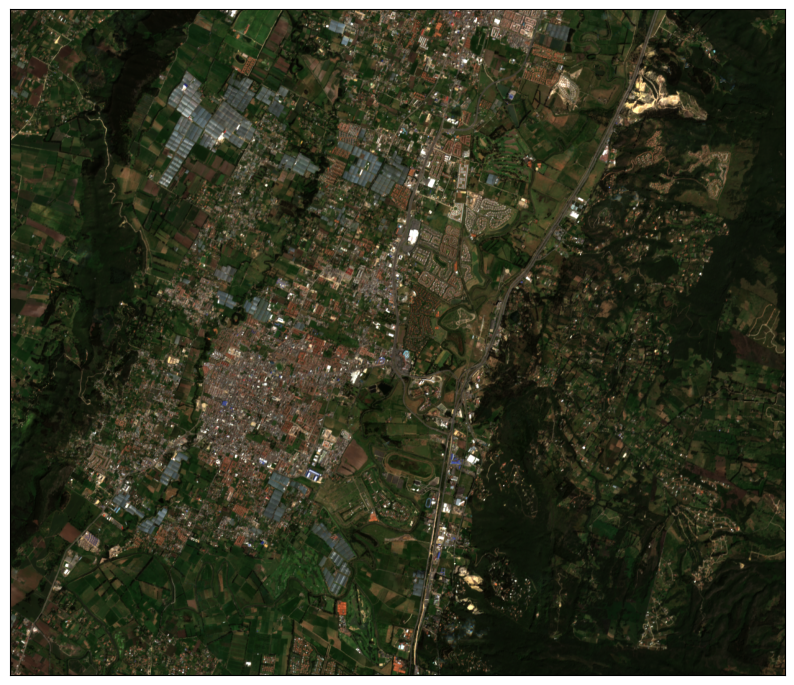

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(nrmlzd, transform=src.transform, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Se revisa la visualización del ráster por banda.

<Axes: title={'center': 'B2'}>

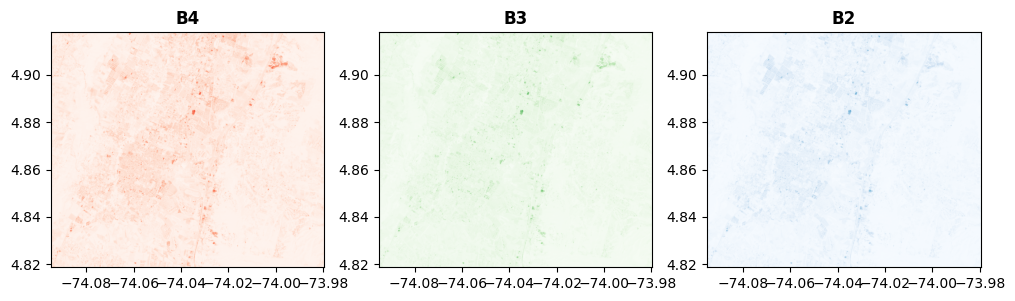

In [22]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(12,4))
show((src, 1), ax=axr, cmap='Reds', title='B4')
show((src, 2), ax=axg, cmap='Greens', title='B3')
show((src, 3), ax=axb, cmap='Blues', title='B2')

Se despliega el histograma con los valores nuevamente normalizados.

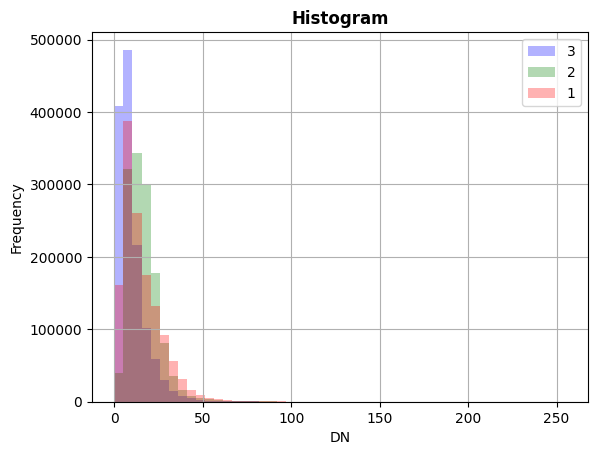

In [23]:
nrmlzd = src.read()
nrmlzd[nrmlzd > nrmlzd.max()] = nrmlzd.max()
nrmlzd = nrmlzd*255/nrmlzd.max()

show_hist(
    nrmlzd,
    bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram"
)

# 3. Redimensionar datos

Esta parte realiza un reshape de la matriz tridimensional, de forma que cada píxel esté representado por una fila y cada capa este representado por una columna. A este también se le conoce como el proceso de desenrollar los datos.

Primero se verifican el tamaño en pixeles del ráster.

In [24]:
nrmlzd.shape

(3, 1072, 1248)

In [25]:
num_cap = nrmlzd.shape[0]
num_fil = nrmlzd.shape[1]
num_col = nrmlzd.shape[2]

Se gira la matriz de valores del ráster con el método _swapaxes_ de numpy.

In [26]:
tabla_datos = np.swapaxes(nrmlzd, axis1=0, axis2=2)

In [27]:
tabla_datos.shape

(1248, 1072, 3)

Se apilan las observaciones por unidad de observación, o sea por píxel.

In [28]:
tabla_datos = pd.DataFrame( tabla_datos.reshape(num_col*num_fil,num_cap) )
tabla_datos = tabla_datos.rename(columns=dict( zip(range(3) , ['B4','B3','B2'] )))
tabla_datos

B4         B3         B2
0        18.559132  17.155689  10.183383
1        14.505988  13.473054   8.532934
2        15.022455  12.159431   9.397455
3        18.053892  15.426647  11.283683
4        18.368263  16.818862  10.969311
...            ...        ...        ...
1337851  24.318862  18.289671  10.901946
1337852  23.982036  17.941617  10.531437
1337853  23.690120  18.222305  10.834581
1337854  23.274701  18.536677  11.261228
1337855  22.533683  18.750000  12.204341

[1337856 rows x 3 columns]

# 4. Clustering

Para aquellas técnicas en que se elije el número de _clusters_ de salida.

In [29]:
num_clusters = 3

Algunas de las técnicas pueden verse limitadas para agrupar el orden de millones de pixeles, por lo que se oopta por generar un conjunto de datos de entrenamiento de la técnica no supervisada para luego expandir los resultados con ayuda de la técnica supervisada del _vecino más cercano_.

In [30]:
dd = tabla_datos.sample(n=int(tabla_datos.shape[0]/100)).reset_index(drop=True)
dd.shape

(13378, 3)

En procura de revisar las gráficas con la misma escala de color.

In [31]:
colorscal = "viridis_r"

## K-means



Se ajusta el modelo no supervisado con el conjunto de datos **completo**.

In [32]:
kmeans = KMeans(n_clusters = num_clusters, random_state = 1234, n_init='auto')

t = time()
kmeans.fit(tabla_datos)
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 2.294s


Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [33]:
dd_kmeans = pd.concat([tabla_datos, pd.DataFrame(kmeans.labels_, columns=['Cl_or'])], axis=1)
dd_kmeans = dd_kmeans.sort_values(by='B2')
dd_kmeans['copy_index'] = dd_kmeans.index
homol = pd.DataFrame( {'Cl_or': dd_kmeans['Cl_or'].unique(), 'Cluster': range(len(dd_kmeans['Cl_or'].unique()))} )
dd_kmeans = pd.merge(dd_kmeans, homol).drop('Cl_or', axis=1)
del homol

Se genera el diagrama de dispersión de los valores de las bandas de cada pixel y se etiquetan por colores según su cluster.

In [ ]:
fig = px.scatter_3d(dd_kmeans.sample(n=int(tabla_datos.shape[0]/10)), x='B4', y='B3', z='B2', color='Cluster', color_continuous_scale=colorscal)
fig.update_traces(marker=dict(size=0.5))
fig.update_layout(title = 'Valores de pixeles y clusters por K-means. Sentinel Chía 2018', height=500, width=700, coloraxis_showscale=False)
fig.show()
fig.write_html("scatterplot_Sentinel_Chia_2018_kmeans.html")

Se revisa la distribución de los pixeles por cluster.



In [35]:
dd_kmeans.Cluster.value_counts()

Cluster
0    863888
1    419577
2     54391
Name: count, dtype: int64

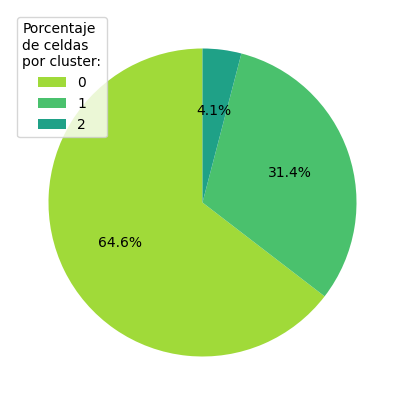

In [36]:
sizs = (dd_kmeans.Cluster.value_counts()/dd_kmeans.Cluster.value_counts().sum()).to_list()
nams = range(dd_kmeans.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

Se reconstruye la imagen para revisar la distribución espacial de los clusters.



In [37]:
rconst_cl = dd_kmeans.sort_values(by='copy_index').Cluster.values.reshape(num_col,num_fil)
rconst_cl = np.swapaxes(rconst_cl, axis1=0, axis2=1)

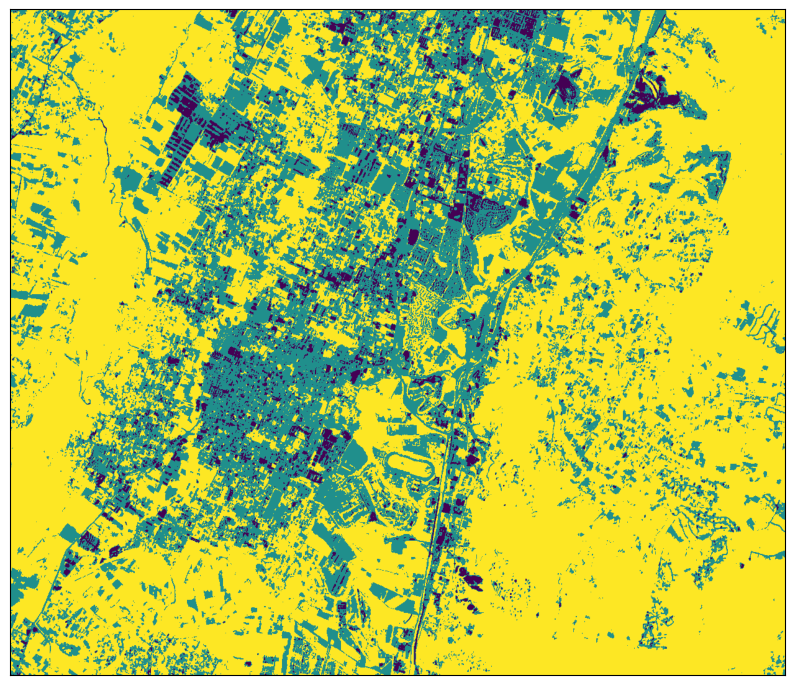

In [38]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(rconst_cl, cmap = plt.get_cmap(colorscal), ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Hierarchical Clustering (+) K nearest neighbors


Se ajusta el modelo no supervisado con la **muestra** del conjunto de datos.

In [39]:
ward = AgglomerativeClustering(n_clusters=num_clusters, linkage='average')

t = time()
ward.fit(dd)
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 11.016s


Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.



In [40]:
dd_ward = pd.concat([dd, pd.DataFrame(ward.labels_, columns=['Cl_or'])], axis=1)
dd_ward = dd_ward.sort_values(by='B4')
dd_ward['copy_index'] = dd_ward.index
homol = pd.DataFrame( {'Cl_or': dd_ward['Cl_or'].unique(), 'Cluster': range(len(dd_ward['Cl_or'].unique()))} )
dd_ward = pd.merge(dd_ward, homol).drop(['Cl_or','copy_index'], axis=1)
del homol

Se genera el diagrama de dispersión de los valores de las bandas de cada pixel y se etiquetan por colores según su cluster.

In [ ]:
fig = px.scatter_3d(dd_ward, x='B4', y='B3', z='B2', color='Cluster', color_continuous_scale=colorscal)
fig.update_traces(marker=dict(size=0.5))
fig.update_layout(title = 'Valores de pixeles y clusters por Ward. Sentinel Chía 2018', height=500, width=700, coloraxis_showscale=False)
fig.show()
fig.write_html("scatterplot_Sentinel_Chia_2018_ward.html")

Se revisa la distribución de los pixeles por cluster.

In [42]:
dd_ward.Cluster.value_counts()

Cluster
0    13360
1       17
2        1
Name: count, dtype: int64

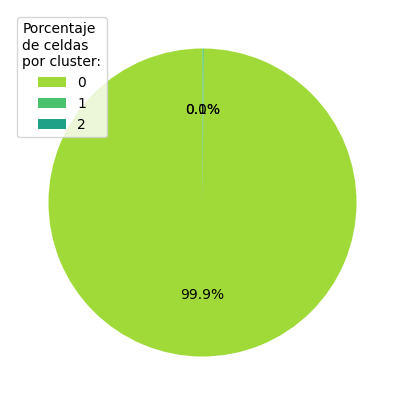

In [43]:
sizs = (dd_ward.Cluster.value_counts()/dd_ward.Cluster.value_counts().sum()).to_list()
nams = range(dd_ward.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

### K nearest neighbors

Se entrena un modelo de _vecino más cercano_ con las etiquetas de los clusters antes generados y se aplica al conjunto de datos completo.



In [44]:
nn_ward = KNeighborsClassifier(n_neighbors=1)

t = time()
nn_ward.fit( dd_ward[['B4','B3','B2']] , dd_ward.Cluster.values.ravel() )
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 0.014s


In [45]:
ward_labels = nn_ward.predict(tabla_datos)

Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [46]:
dd_ward_nn = pd.concat([tabla_datos, pd.DataFrame(ward_labels , columns=['Cl_or'])], axis=1)
dd_ward_nn = dd_ward_nn.sort_values(by='B4')
dd_ward_nn['copy_index'] = dd_ward_nn.index
homol = pd.DataFrame( {'Cl_or': dd_ward_nn['Cl_or'].unique(), 'Cluster': range(len(dd_ward_nn['Cl_or'].unique()))} )
dd_ward_nn = pd.merge(dd_ward_nn, homol).drop(['Cl_or','copy_index'], axis=1)
del homol

De nuevo, se revisa la distribución de los pixeles por cluster para el conjunto de datos completo.

In [47]:
dd_ward_nn.Cluster.value_counts()

Cluster
0    1335951
1       1748
2        157
Name: count, dtype: int64

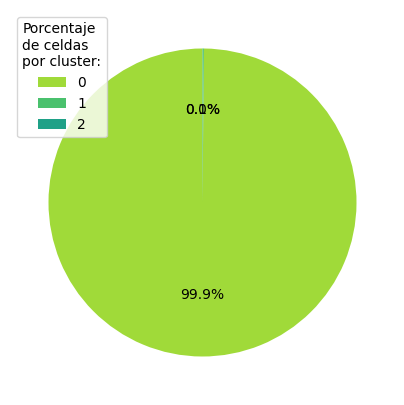

In [48]:
sizs = (dd_ward_nn.Cluster.value_counts()/dd_ward_nn.Cluster.value_counts().sum()).to_list()
nams = range(dd_ward.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

Se reconstruye la imagen para revisar la distribución espacial de los clusters.

In [49]:
rconst_cl = ward_labels.reshape(num_col,num_fil)
rconst_cl = np.swapaxes(rconst_cl, axis1=0, axis2=1)

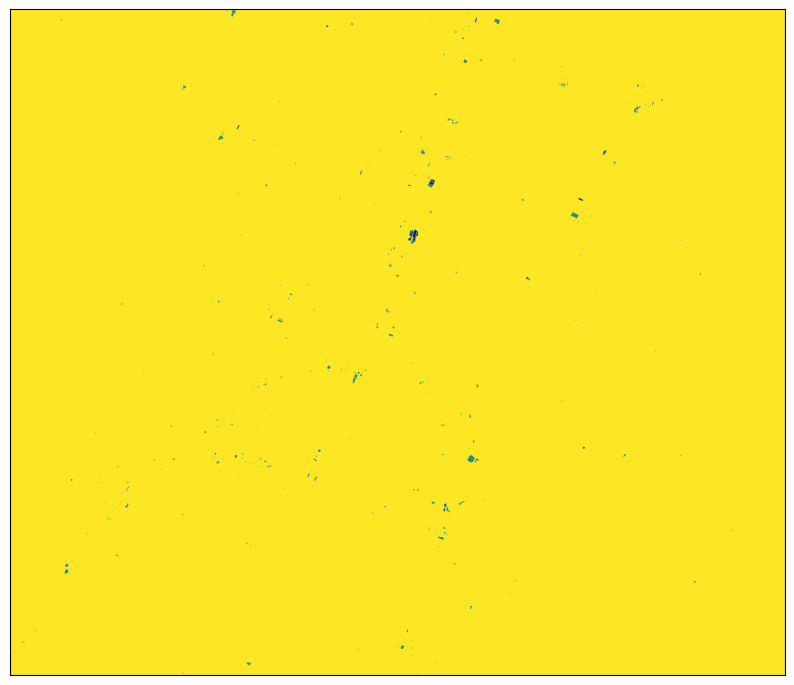

In [50]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(rconst_cl, cmap = plt.get_cmap(colorscal), ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## DBSCAN (+) K Nearest Neighbors

Se ajusta el modelo no supervisado con la **muestra** del conjunto de datos.

In [51]:
dbscan = DBSCAN(eps=0.8, min_samples=25)

t = time()
dbscan_labels = dbscan.fit_predict(dd) + 1
dbscan_labels = np.where(dbscan_labels==0,1,np.where(dbscan_labels==1,0,dbscan_labels)) # para arreglar colores
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 0.197s


Se verifica la distribución de los pixeles por cluster y se verifica el número de clusters resultante en la corrida.

In [52]:
unique, counts = np.unique(dbscan_labels, return_counts=True)
dbscan_conts = pd.DataFrame( {'Cluster': unique, 'count': counts} )
dbscan_conts.set_index('Cluster', inplace=True)
dbscan_conts

count
Cluster       
0         9074
1         4304

### K nearest neighbors

Se entrena un modelo de _vecino más cercano_ con las etiquetas de los clusters antes generados y se aplica al conjunto de datos completo.

In [53]:
nn_dbscan = KNeighborsClassifier(n_neighbors=1)

t = time()
nn_dbscan.fit( dd , dbscan_labels )
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 0.011s


In [54]:
t = time()
dbscan_labels = nn_dbscan.predict(tabla_datos) + 1
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 82.827s


Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [55]:
dd_dbscan = pd.concat([dd, pd.DataFrame(dbscan_labels, columns=['Cl_or'])], axis=1)
dd_dbscan = dd_dbscan.sort_values(by='B4')
dd_dbscan['copy_index'] = dd_dbscan.index
homol = pd.DataFrame( {'Cl_or': dd_dbscan['Cl_or'].unique(), 'Cluster': range(len(dd_dbscan['Cl_or'].unique()))} )
dd_dbscan = pd.merge(dd_dbscan, homol).drop(['Cl_or','copy_index'], axis=1)
del homol

Se genera el diagrama de dispersión de los valores de las bandas de cada pixel y se etiquetan por colores según su cluster.

In [ ]:
fig = px.scatter_3d(dd_dbscan, x='B4', y='B3', z='B2', color='Cluster', color_continuous_scale=colorscal)
fig.update_traces(marker=dict(size=0.5))
fig.update_layout(title = 'Valores de pixeles y clusters por DBSCAN. Sentinel Chía 2018', height=500, width=700, coloraxis_showscale=False)
fig.show()
fig.write_html("scatterplot_Sentinel_Chia_2018_dbscan.html")

Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [57]:
dd_dbscan_nn = pd.concat([tabla_datos, pd.DataFrame(dbscan_labels , columns=['Cl_or'])], axis=1)
dd_dbscan_nn = dd_dbscan_nn.sort_values(by='B4')
dd_dbscan_nn['copy_index'] = dd_dbscan_nn.index
homol = pd.DataFrame( {'Cl_or': dd_dbscan_nn['Cl_or'].unique(), 'Cluster': range(len(dd_dbscan_nn['Cl_or'].unique()))} )
dd_dbscan_nn = pd.merge(dd_dbscan_nn, homol).drop(['Cl_or','copy_index'], axis=1)
del homol

Se revisa la distribución de los pixeles por cluster.

In [58]:
dd_dbscan_nn.Cluster.value_counts().sort_index()

Cluster
0    426499
1    911357
Name: count, dtype: int64

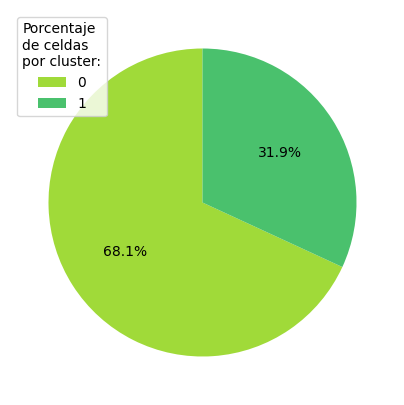

In [59]:
sizs = (dd_dbscan_nn.Cluster.value_counts()/dd_dbscan_nn.Cluster.value_counts().sum()).to_list()
nams = range(dd_dbscan_nn.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

Se reconstruye la imagen para revisar la distribución espacial de los clusters.

In [60]:
rconst_cl = dbscan_labels.reshape(num_col,num_fil)
rconst_cl = np.swapaxes(rconst_cl, axis1=0, axis2=1)

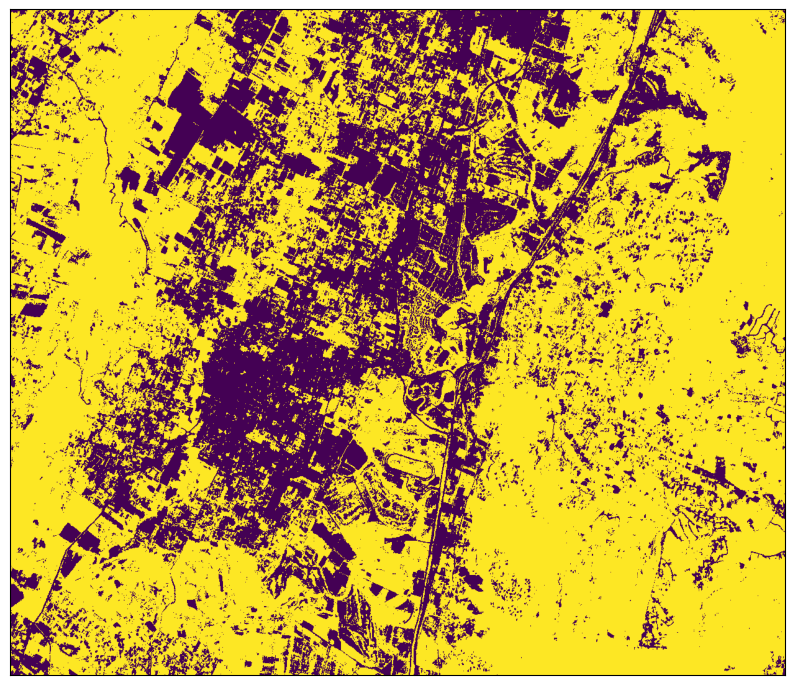

In [61]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(rconst_cl, cmap = plt.get_cmap(colorscal), ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Spectral Clustering (+) K nearest neighbors

Se ajusta el modelo no supervisado con una **muestra de la muestra** del conjunto de datos.

In [62]:
ddd = tabla_datos.sample(n=int(tabla_datos.shape[0]/100000)).reset_index(drop=True)
spectr = SpectralClustering(n_clusters = num_clusters, affinity ='rbf')

t = time()
spectr_labels = spectr.fit_predict(ddd)
#spectr_labels = np.where(spectr_labels==0,2,np.where(spectr_labels==0,2,spectr_labels)) # para arreglar colores
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 0.084s


Se verifica la distribución de los pixeles por cluster y se verifica el número de clusters resultante en la corrida.

In [63]:
unique, counts = np.unique(spectr_labels, return_counts=True)
spectr_conts = pd.DataFrame( {'Cluster': unique, 'count': counts} )
spectr_conts.set_index('Cluster', inplace=True)
spectr_conts

count
Cluster       
0            8
1            2
2            3

### K nearest neighbors

Se entrena un modelo de _vecino más cercano_ con las etiquetas de los clusters antes generados y se aplica al conjunto de datos completo.

In [64]:
nn_spectr = KNeighborsClassifier(n_neighbors=1)

t = time()
nn_spectr.fit( ddd , spectr_labels )
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 0.005s


In [65]:
t = time()
spectr_labels = nn_spectr.predict(tabla_datos)
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 77.782s


Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [66]:
dd_spectr = pd.concat([dd, pd.DataFrame(spectr_labels, columns=['Cl_or'])], axis=1)
dd_spectr = dd_spectr.sort_values(by='B4')
dd_spectr['copy_index'] = dd_spectr.index
homol = pd.DataFrame( {'Cl_or': dd_spectr['Cl_or'].unique(), 'Cluster': range(len(dd_spectr['Cl_or'].unique()))} )
dd_spectr = pd.merge(dd_spectr, homol).drop(['Cl_or','copy_index'], axis=1)
del homol

Se genera el diagrama de dispersión de los valores de las bandas de cada pixel y se etiquetan por colores según su cluster.

In [ ]:
fig = px.scatter_3d(dd_spectr, x='B4', y='B3', z='B2', color='Cluster', color_continuous_scale=colorscal)
fig.update_traces(marker=dict(size=0.5))
fig.update_layout(title = 'Valores de pixeles y clusters por Spectral Clsutering. Sentinel Chía 2018', height=500, width=700, coloraxis_showscale=False)
fig.show()
fig.write_html("scatterplot_Sentinel_Chia_2018_spectr.html")

Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [68]:
dd_spectr_nn = pd.concat([tabla_datos, pd.DataFrame(spectr_labels , columns=['Cl_or'])], axis=1)
dd_spectr_nn = dd_spectr_nn.sort_values(by='B4')
dd_spectr_nn['copy_index'] = dd_spectr_nn.index
homol = pd.DataFrame( {'Cl_or': dd_spectr_nn['Cl_or'].unique(), 'Cluster': range(len(dd_spectr_nn['Cl_or'].unique()))} )
dd_spectr_nn = pd.merge(dd_spectr_nn, homol).drop(['Cl_or','copy_index'], axis=1)
del homol

Se revisa la distribución de los pixeles por cluster.

In [69]:
dd_spectr_nn.Cluster.value_counts()

Cluster
0    821972
1    346359
2    169525
Name: count, dtype: int64

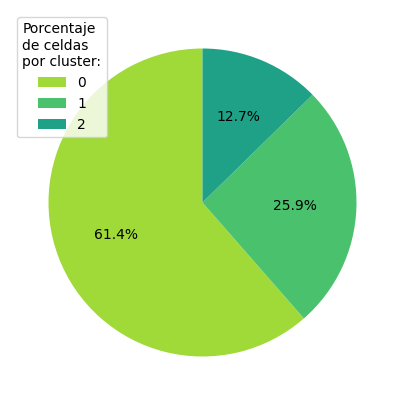

In [70]:
sizs = (dd_spectr_nn.Cluster.value_counts()/dd_spectr_nn.Cluster.value_counts().sum()).to_list()
nams = range(dd_spectr_nn.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

Se reconstruye la imagen para revisar la distribución espacial de los clusters.

In [71]:
rconst_cl = spectr_labels.reshape(num_col,num_fil)
rconst_cl = np.swapaxes(rconst_cl, axis1=0, axis2=1)

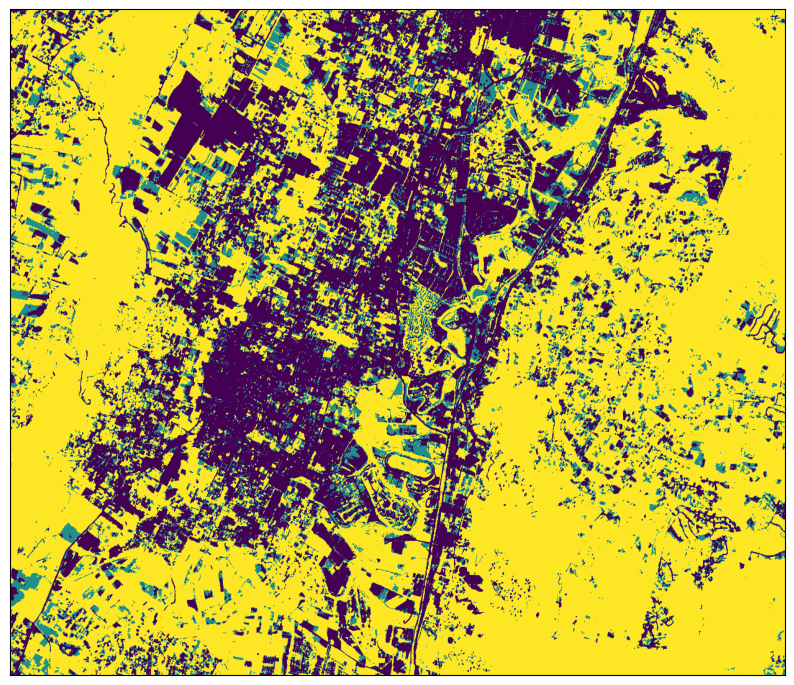

In [72]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(rconst_cl, cmap = plt.get_cmap(colorscal), ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## BIRCH

Se ajusta el modelo no supervisado con el conjunto de datos **completo**.

In [73]:
birch = Birch(branching_factor = 50, n_clusters = num_clusters, threshold = 1.5)

t = time()
birch.fit(tabla_datos)
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 125.733s


In [74]:
t = time()
birch_labels = birch.predict(tabla_datos)
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 80.941s


Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [75]:
dd_birch = pd.concat([tabla_datos, pd.DataFrame(birch.labels_, columns=['Cl_or'])], axis=1)
dd_birch = dd_birch.sort_values(by='B2')
dd_birch['copy_index'] = dd_birch.index
homol = pd.DataFrame( {'Cl_or': dd_birch['Cl_or'].unique(), 'Cluster': range(len(dd_birch['Cl_or'].unique()))} )
dd_birch = pd.merge(dd_birch, homol).drop('Cl_or', axis=1)
del homol

Se genera el diagrama de dispersión de los valores de las bandas de cada pixel y se etiquetan por colores según su cluster.

In [ ]:
fig = px.scatter_3d(dd_birch.sample(n=int(tabla_datos.shape[0]/10)), x='B4', y='B3', z='B2', color='Cluster', color_continuous_scale=colorscal)
fig.update_traces(marker=dict(size=0.5))
fig.update_layout(title = 'Valores de pixeles y clusters por BIRCH. Sentinel Chía 2018', height=500, width=700, coloraxis_showscale=False)
fig.show()
fig.write_html("scatterplot_Sentinel_Chia_2018_birch.html")

Se revisa la distribución de los pixeles por cluster.

In [77]:
dd_birch.Cluster.value_counts()

Cluster
0    1329378
1       7128
2       1350
Name: count, dtype: int64

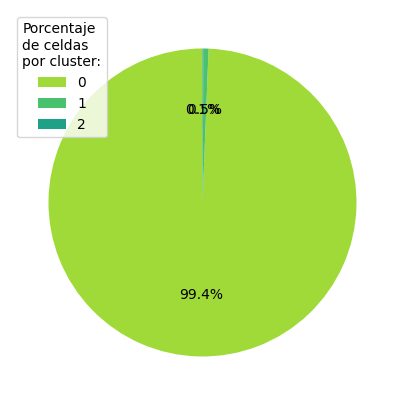

In [78]:
sizs = (dd_birch.Cluster.value_counts()/dd_birch.Cluster.value_counts().sum()).to_list()
nams = range(dd_birch.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

Se reconstruye la imagen para revisar la distribución espacial de los clusters.

In [79]:
rconst_cl = dd_birch.sort_values(by='copy_index').Cluster.values.reshape(num_col,num_fil)
rconst_cl = np.swapaxes(rconst_cl, axis1=0, axis2=1)

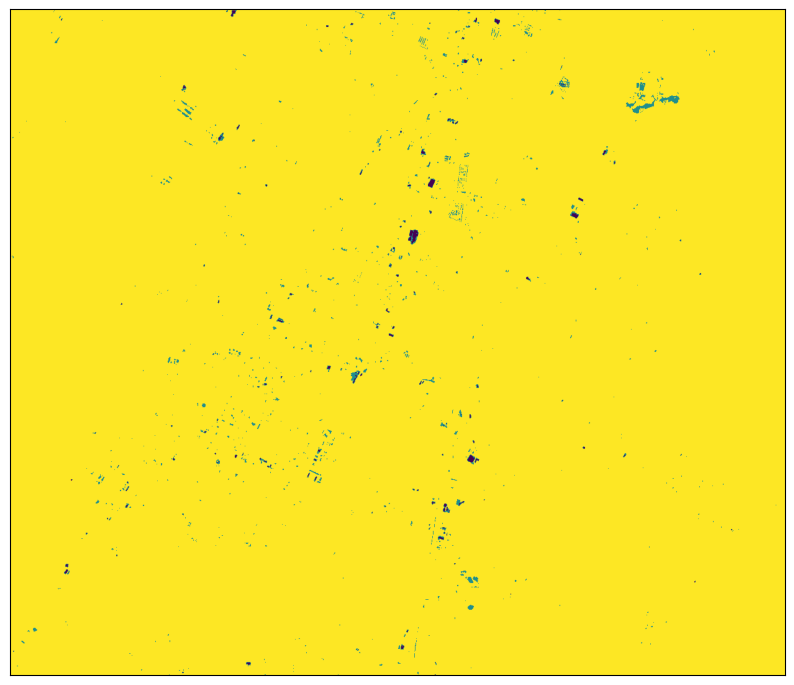

In [80]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(rconst_cl, cmap = plt.get_cmap(colorscal), ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## PCA (+) K-means

Basados en la forma de la nube de puntos del diuagrama de dispersión, se propone realizale a estos datos un PCA para reducir los datos a una sola dimensión.

Se ajusta el modelo y se transforman los datos. Recordar que estos ya fueron escalados y se revisa el porcentaje de varianza contenida en ese primer componente principal.

In [81]:
pca = PCA(1)
pca_kmeans_labels = pca.fit_transform(tabla_datos)

In [82]:
print(pca.explained_variance_ratio_)

[0.96269342]


Se ajusta el modelo no supervisado con el conjunto de datos **completo**.

In [83]:
pca_kmeans = KMeans(n_clusters = num_clusters, random_state = 1234, n_init='auto')

t = time()
pca_kmeans.fit(pca_kmeans_labels)
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Tiempo de ejecución: 0.689s


Se organizan las etiquetas de los clusters antes generados de menor a mayor de acuerdo a los valores de una de las bandas.

In [84]:
dd_pca_kmeans = pd.concat([tabla_datos, pd.DataFrame(pca_kmeans.labels_, columns=['Cl_or'])], axis=1)
dd_pca_kmeans = dd_pca_kmeans.sort_values(by='B2')
dd_pca_kmeans['copy_index'] = dd_pca_kmeans.index
homol = pd.DataFrame( {'Cl_or': dd_pca_kmeans['Cl_or'].unique(), 'Cluster': range(len(dd_pca_kmeans['Cl_or'].unique()))} )
dd_pca_kmeans = pd.merge(dd_pca_kmeans, homol).drop('Cl_or', axis=1)
del homol

Se genera el diagrama de dispersión de los valores de las bandas de cada pixel y se etiquetan por colores según su cluster.

In [ ]:
fig = px.scatter_3d(dd_pca_kmeans.sample(n=int(tabla_datos.shape[0]/10)), x='B4', y='B3', z='B2', color='Cluster', color_continuous_scale=colorscal)
fig.update_traces(marker=dict(size=0.5))
fig.update_layout(title = 'Valores de pixeles y clusters por PCA K-means. Sentinel Chía 2018', height=500, width=700, coloraxis_showscale=False)
fig.show()
fig.write_html("scatterplot_Sentinel_Chia_2018_pca_kmeans.html")

Se revisa la distribución de los pixeles por cluster.

In [86]:
dd_pca_kmeans.Cluster.value_counts()

Cluster
0    873033
1    414950
2     49873
Name: count, dtype: int64

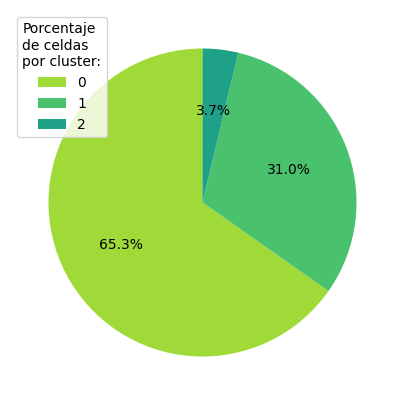

In [87]:
sizs = (dd_pca_kmeans.Cluster.value_counts()/dd_kmeans.Cluster.value_counts().sum()).to_list()
nams = range(dd_kmeans.Cluster.value_counts().shape[0])

plt.subplots(figsize=(5, 5))
plt.pie(sizs, autopct='%1.1f%%', startangle=90, colors=sns.color_palette(colorscal))
plt.legend(loc='upper left', labels=nams, title='Porcentaje\nde celdas\npor cluster:')
plt.show()

Se reconstruye la imagen para revisar la distribución espacial de los clusters.

In [88]:
rconst_cl = dd_pca_kmeans.sort_values(by='copy_index').Cluster.values.reshape(num_col,num_fil)
rconst_cl = np.swapaxes(rconst_cl, axis1=0, axis2=1)

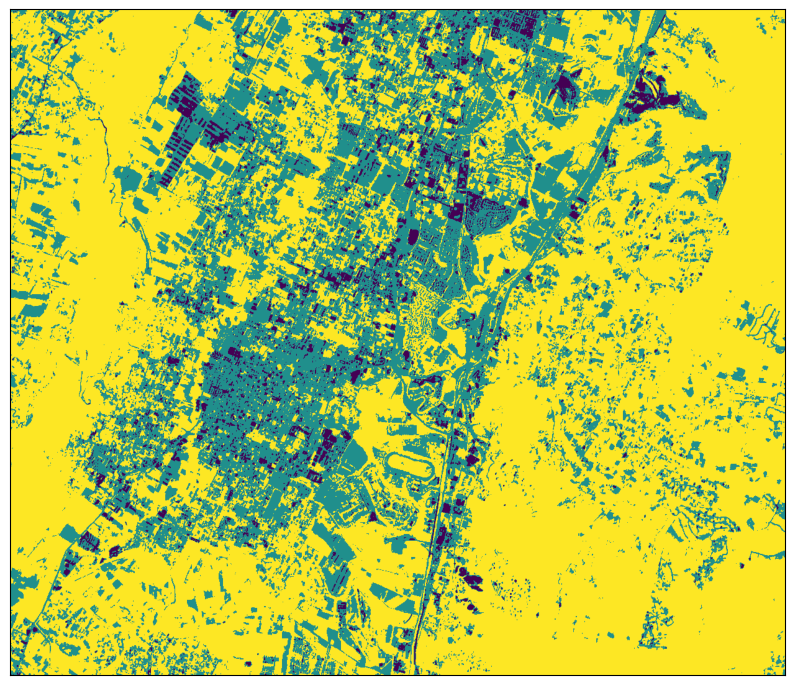

In [89]:
fig, ax = plt.subplots(1, figsize=(10,10))
show(rconst_cl, cmap = plt.get_cmap(colorscal), ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Validación con métricas de clustering

A continuación, se calculan tres métricas para la comparación de resultados entre diferentes resultados de clustering, únicamente para uno de los modelos ajustados.

In [90]:
t = time()
db_score = davies_bouldin_score(tabla_datos, dd_pca_kmeans.Cluster)
print(f"Índice Davies-Bouldin: {db_score}")
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Índice Davies-Bouldin: 3.093127863416808
Tiempo de ejecución: 0.236s


In [91]:
t = time()
ch_score = calinski_harabasz_score(tabla_datos, dd_pca_kmeans.Cluster)
print(f"Índice Calinski-Harabasz: {ch_score}")
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Índice Calinski-Harabasz: 44158.6026895215
Tiempo de ejecución: 0.195s


In [92]:
xa_validar = pd.concat([tabla_datos.reset_index(drop=True), dd_pca_kmeans.Cluster], axis=1)
xa_validar = xa_validar.sample(n=int(xa_validar.shape[0]/5)).reset_index(drop=True)

t = time()
#sil_score = silhouette_score(tabla_datos, dd_pca_kmeans.Cluster)
sil_score = silhouette_score(xa_validar[['B4','B3','B2']], xa_validar[['Cluster']].values.ravel())
print(f"Silhouette Score: {sil_score}")
print("Tiempo de ejecución: %0.3fs" % (time() - t))

Silhouette Score: -0.19756869009022765
Tiempo de ejecución: 873.161s
